# Untokenizing Video Sequences 

Here we create a function to transform spacetime-patched videos back into their original `[frames, height, width, channels]` tensor. 

## Imports + Data Acquisition

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

2022-10-24 18:10:41.581812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 18:10:41.714020: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-24 18:10:41.739497: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-24 18:10:42.254797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## GPU Setup
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 40
output_size = (120, 180)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


  0%|          | 0/16 [00:00<?, ?it/s]2022-10-24 18:10:43.292960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 18:10:44.228451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-24 18:10:44.229182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:68:00.0, compute capability: 8.6
100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


Making patches from Videoset...
Making the flat patch set...
Adding codes to the PatchSet...
Flattening the coded + patched dataset...


In [4]:
## Obtaining a single greyscale frame from a video

video_num = 2

frame_list = []

# Getting a candidate frame 
cnt = 0
for element in VideoSet: 
	cnt += 1
	candidate_frame = element
	reconstruct_me = candidate_frame[:, -1, :,:,0]

	## Now with basic positional encoding
	video_height = reconstruct_me.shape[-2]
	pos_code = tf.range(0, 1, 1/video_height) 
	pos_code = tf.expand_dims(pos_code, axis=0)
	pos_code = tf.expand_dims(pos_code, axis=-1)

	poscode_reconstruct_me = tf.concat([reconstruct_me, pos_code], axis=2)
	poscode_reconstruct_me.shape
	frame_list.append(poscode_reconstruct_me)

Shape of poscode reconstruction tensor:  (16, 120, 181)


Text(0.5, 0.98, 'Source frames')

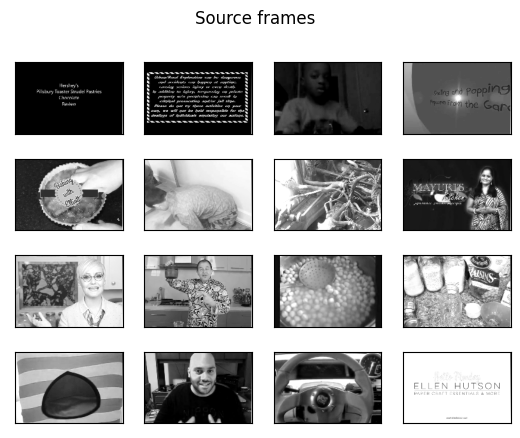

In [5]:
poscode_reconstruct_me = tf.concat(frame_list, axis=0)
print("Shape of poscode reconstruction tensor: ", poscode_reconstruct_me.shape)

fig, axs = plt.subplots(4,4)

for i in range(4): 
	for j in range(4): 
		axs[i,j].imshow(poscode_reconstruct_me[i+j*4,:,:], cmap='gray')
		axs[i,j].set_xticks([])
		axs[i,j].set_yticks([])

plt.suptitle("Source frames")

## Single Video Example

Original video shape:  (1, 40, 120, 180, 3)
Patched video shape:  (1, 13, 7, 11, 2304)
patch_height, patch_width, patch_duration (16, 16, 3)


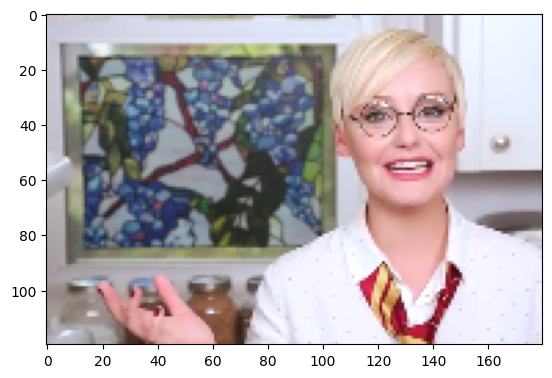

In [6]:
original_video = None 
patched_video = None

vid_num = 3

cnt=0
for element in VideoSet: 
	cnt += 1
	original_video = element 
	if cnt == vid_num: 
		break

cnt = 0
for element in PatchSet: 
	cnt += 1
	patched_video = element
	if cnt == vid_num: 
		break

print("Original video shape: ", original_video.shape)
print("Patched video shape: ", patched_video.shape)
print("patch_height, patch_width, patch_duration", (patch_height, patch_width, patch_duration))

plt.imshow(original_video[0,-1,:,:,:])

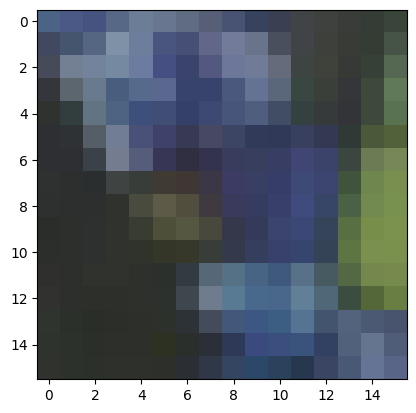

In [7]:
patch0 = patched_video[0,-1,3,5,:]
patch0 = tf.reshape(patch0, [3, 16, 16, 3])
plt.imshow(patch0[0,:,:,:])

In [8]:
new_patched_video_shape = patched_video.shape[:-1] + [patch_duration, patch_height, patch_width, 3]
new_patched = tf.reshape(patched_video, new_patched_video_shape)
new_patched.shape

TensorShape([1, 13, 7, 11, 3, 16, 16, 3])

Text(0.5, 0.98, 'Patch Mosaic')

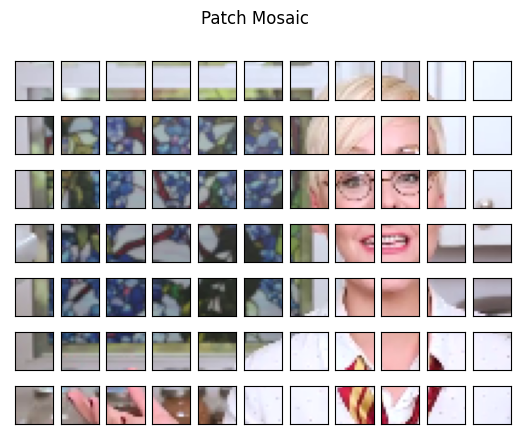

In [9]:
fig, axs = plt.subplots(7, 11) 

for i in range(7): 
	for j in range(11): 
		axs[i,j].imshow(new_patched[0,-1, i, j, 0,:,:,:])
		axs[i,j].set_xticks([])
		axs[i,j].set_yticks([])

plt.suptitle("Patch Mosaic")

In [10]:
new_patched.shape

# plot_slice = new_patched[0,-1, :, :, 0,:,:,:] # last frame, 0th batch #, first time slice 
# plot_slice.shape|

TensorShape([1, 13, 7, 11, 3, 16, 16, 3])

In [11]:
unpatched_width = tf.concat([new_patched[:, :, i, :, :, :, :] for i in range(7)], axis=4)
unpatched_width.shape

TensorShape([1, 13, 11, 3, 112, 16, 3])

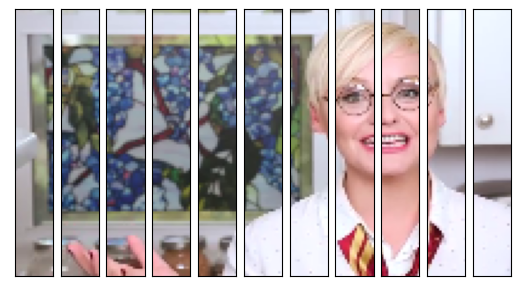

In [12]:
fig, axs = plt.subplots(1,11) 

for i in range(11): 
	slice =unpatched_width[0, -1, i, 0, :, :,:]
	axs[i].imshow(slice)
	axs[i].set_xticks([])
	axs[i].set_yticks([])

In [13]:
unpatched_width_height = tf.concat([unpatched_width[:,:,i,:,:,:,:] for i in range(11)], axis=4)
unpatched_width_height.shape

TensorShape([1, 13, 3, 112, 176, 3])

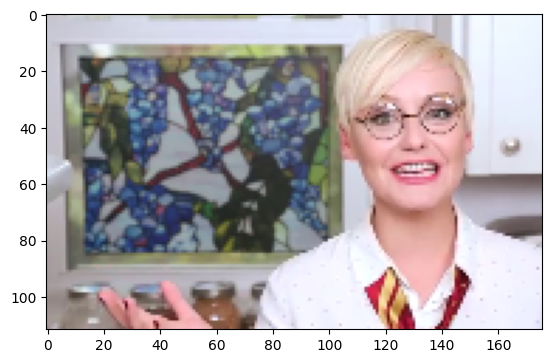

In [14]:
plt.imshow(unpatched_width_height[0, -1, 0, :, :,:])

In [15]:
unpatched_time_height_width = tf.concat([unpatched_width_height[:,i,:,:,:,:] for i in range(13)], axis=1)
unpatched_time_height_width.shape

TensorShape([1, 39, 112, 176, 3])

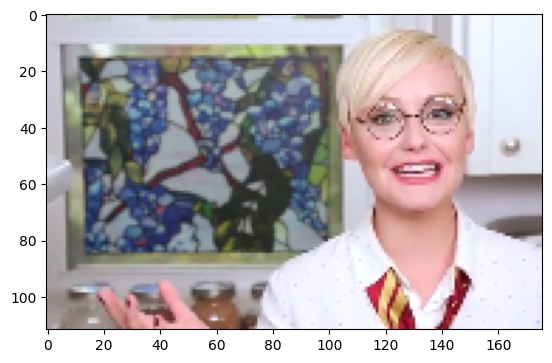

In [16]:
plt.imshow(unpatched_time_height_width[0,-1,:,:,:]) # back to the original shape!!!!

## How to do spacetime windowing on patchset

How can we select a certain time range from the patchset format? 

Let's make a fake videoset that monotonically gets brighter over time. Then we can 
observe the patched version to see if the time dimension is the top-level one!

In [29]:
bright_frame = tf.ones([1,256,256,3])
linear_ramp = tf.range(0,1,delta=0.01)

video_tensor = tf.concat([bright_frame*linear_ramp[i] for i in range(len(linear_ramp))], axis=0)
video_tensor = tf.expand_dims(video_tensor, axis=0)
video_tensor.shape

TensorShape([1, 100, 256, 256, 3])

In [30]:
def create_patches(video_tensor, ksizes=[1,4,16,16,1]): 
	"""Converts `video_tensor` into a sequence of patches.
	Input has shape [frames, width, height, channels]

	ksizes=[1,4,16,16,1] -> 4 temporal depth, 16 height/width. 
	"""
	return tf.extract_volume_patches(video_tensor, ksizes,ksizes,"VALID")

patch_tensor = create_patches(video_tensor)
print("Patch tensor shape: ", patch_tensor.shape)



Patch tensor shape:  (1, 25, 16, 16, 3072)


In [31]:
def flatten_patched(patch_tensor, batch_size=1):
		""" Flattens the 3D structure of spacetime patches into a [batch, num_patches, patch_len] 
		tensor. Should be applied after positional encoding, generally. 
		"""
		# print("Flattening a tensor of shape: ", patch_tensor.shape)
		b, t, h, w, cs = patch_tensor.shape
		return tf.reshape(patch_tensor, [batch_size, t*h*w, cs])

flat_tensor = flatten_patched(patch_tensor)
print("Flat tensor shape: ", flat_tensor.shape)

Flat tensor shape:  (1, 6400, 3072)


Text(0.5, 1.0, 'TIME IS INDEED THE TOP-LEVEL DIMENSION!')

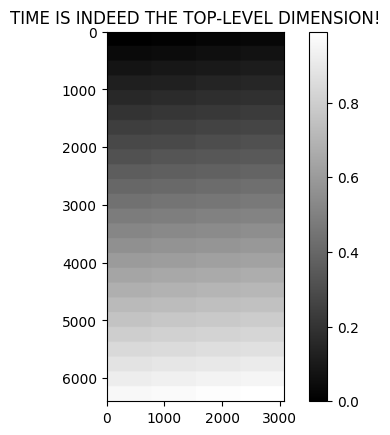

In [35]:
plt.imshow(flat_tensor[0,:,:],cmap='gray')
plt.colorbar()
plt.title("TIME IS INDEED THE TOP-LEVEL DIMENSION!")